In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import torch as t
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
import pickle

%matplotlib inline

/home/tadenoud/Git/simple-faster-rcnn-pytorch/utils/vis_tool.py:8: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


In [2]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

# Load model trained with caffe pretrained model

In [3]:
trainer.load('./checkpoints/fasterrcnn_02272314_0.6720744290992889')
opt.caffe_pretrain=True # this model was trained from caffe-pretrained model

In [4]:
img = read_image('misc/demo.jpg')
img = t.from_numpy(img)[None]

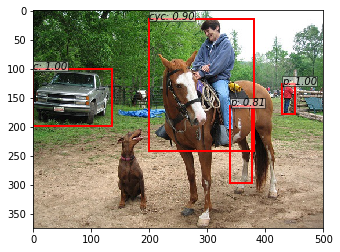

In [5]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# Display a Kitti image

In [6]:
import os

# dataset_dir = '/media/tadenoud/DATADisk/datasets/kitti_2d'  # School comp
dataset_dir = '/home/tadenoud/Documents/kitti' # Laptop

img_paths = [
    os.path.join(dataset_dir, 'training/image_2/005009.png'),
    os.path.join(dataset_dir, 'training/image_2/005010.png')
]

imgs = np.array([read_image(p) for p in img_paths])

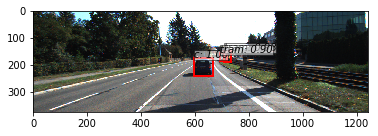

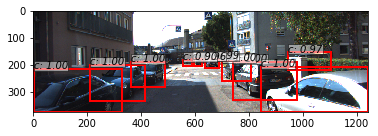

In [7]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(imgs,visualize=True)
vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

vis_bbox(at.tonumpy(imgs[1]),
         at.tonumpy(_bboxes[1]),
         at.tonumpy(_labels[1]).reshape(-1),
         at.tonumpy(_scores[1]).reshape(-1))

In [8]:
# Read a Kitti GT label
from data.util import read_bbox

img_label_paths = [
    os.path.join(dataset_dir, 'training/label_2/005009.txt'),
    os.path.join(dataset_dir, 'training/label_2/005010.txt')
]

gt = np.array([read_bbox(p, ignore_dontcare=True) for p in img_label_paths]) 
gt_bboxes = gt[:,0]
gt_labels = gt[:,1]

scales = np.array([[im.shape[2] / im.shape[1]] for im in imgs])

print(scales)

[[3.312]
 [3.312]]


In [9]:
# _bboxes, _labels, _scores = trainer.faster_rcnn._predict_gt_features_bbox_method(imgs, gt_bboxes, gt_labels, scales)
# vis_bbox(at.tonumpy(imgs[0]),
#          at.tonumpy(_bboxes[0]),
#          at.tonumpy(_labels[0]).reshape(-1),
#          at.tonumpy(_scores[0]).reshape(-1))

# vis_bbox(at.tonumpy(imgs[1]),
#          at.tonumpy(_bboxes[1]),
#          at.tonumpy(_labels[1]).reshape(-1),
#          at.tonumpy(_scores[1]).reshape(-1))

# Train mahalanobis features with entire training dataset

In [10]:
from utils.config import opt
from data.dataset import Dataset, TestDataset
from torch.utils.data import DataLoader


print('load data') 
dataset = Dataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

# mahal_means, mahal_cov = trainer.faster_rcnn.train_ood(dataloader)

# with open('kitti_features.pickle', 'wb') as f:
#     pickle.dump(trainer.faster_rcnn.features, f)
    
# with open('mahal_means.pickle', 'wb') as f:
#     pickle.dump(mahal_means, f)

# with open('mahal_cov.pickle', 'wb') as f:
#     pickle.dump(mahal_cov, f)

# with open('inv_mahal_cov.pickle', 'wb') as f:
#     pickle.dump(trainer.faster_rcnn.inv_mahal_cov, f)

with open('kitti_features.pickle', 'rb') as f:
    trainer.faster_rcnn.features = pickle.load(f)
    
with open('mahal_means.pickle', 'rb') as f:
    mahal_means = pickle.load(f)
    trainer.faster_rcnn.mahal_means = mahal_means
        
with open('mahal_cov.pickle', 'rb') as f:
    mahal_cov = pickle.load(f)
    trainer.faster_rcnn.mahal_cov = mahal_cov
    
with open('inv_mahal_cov.pickle', 'rb') as f:
    inv_mahal_cov = pickle.load(f)
    trainer.faster_rcnn.inv_mahal_cov = inv_mahal_cov

load data


In [11]:
print(mahal_means)
print(mahal_cov)

[array([0.02443087, 0.01492815, 0.03372813, ..., 0.01968838, 0.00032887,
       0.06914441], dtype=float32), array([0.06503281, 0.06364122, 0.06933357, ..., 0.04639765, 0.        ,
       0.2724842 ], dtype=float32), array([3.3794433e-02, 7.7540382e-05, 1.4294182e-01, ..., 6.7984825e-03,
       6.5922458e-03, 1.4544952e-01], dtype=float32), array([0.16165015, 0.18807988, 0.21870331, ..., 0.00569214, 0.0737289 ,
       0.01765316], dtype=float32), array([0.        , 0.08186582, 0.00229005, ..., 0.        , 0.00497164,
       0.01317106], dtype=float32), -1, array([0.11216321, 0.00186202, 0.        , ..., 0.        , 0.        ,
       0.5162592 ], dtype=float32), array([0.18972175, 0.05412542, 0.01210119, ..., 0.        , 0.        ,
       0.6724609 ], dtype=float32)]
[[ 3.51046660e-03  7.11757422e-04 -4.22713637e-05 ...  4.30364289e-04
   1.36290199e-04  5.88163396e-04]
 [ 7.11757422e-04  8.20258213e-03  6.47554782e-04 ...  6.21260819e-04
   2.49465536e-04 -1.75626308e-04]
 [-4.227136

In [12]:
print(trainer.faster_rcnn.features.shape)

(2869, 4096)


In [13]:
trainer.faster_rcnn.inv_mahal_cov

array([[  1446159.506704  ,   2947359.26946084,    995347.30131393, ...,
         -5875385.03474413, -10417307.70693544,   1147419.58265706],
       [  2947359.40072106, -14906603.52252287,  -6245891.39350966, ...,
         -7549908.43218391,  -7345701.87144717,   -384542.52562512],
       [   995347.55724425,  -6245891.58577611,  -3102563.8619641 , ...,
         -6618075.36960075,   7983483.56351982,   -564775.97669716],
       ...,
       [ -5875384.6147863 ,  -7549908.54989649,  -6618075.09753334, ...,
         -5592731.50518702, -12251752.81855668,   2391825.22469109],
       [-10417308.3487976 ,  -7345702.39003486,   7983483.34794168, ...,
        -12251752.55161763,  -2323865.27026917,  -7973403.28570751],
       [  1147419.55678009,   -384542.50269476,   -564775.94795876, ...,
          2391825.3627206 ,  -7973403.65748591,    106723.1267784 ]])

In [14]:
from tqdm import tqdm
# gt_labels = []

# for ii, (img, bbox_, label_, scale) in tqdm(enumerate(dataloader), total=3711):
#     gt_labels.append(at.tonumpy(label_[0]))

#     if ii == 3711:
#         break
        
# gt_labels = np.concatenate(gt_labels, axis=0)

# with open('gt_labels.pickle', 'wb') as f:
#     pickle.dump(trainer.faster_rcnn.gt_labels, f)

with open('gt_labels.pickle', 'rb') as f:
    gt_labels = pickle.load(f)

In [15]:
VOC_BBOX_LABEL_NAMES = (
    'car',
    'van',
    'truck',
    'tram',
    'person',
    'person_sitting',
    'cyclist',
    'misc'
    # 'dontcare
)

for j in range(8):
    print(VOC_BBOX_LABEL_NAMES[j], "count:", sum([i == j for i in gt_labels]))

car count: 2111
van count: 133
truck count: 153
tram count: 23
person count: 357
person_sitting count: 0
cyclist count: 66
misc count: 26


In [16]:
print("Zeros in cov matrix:", (lambda a, b: a * b)(*mahal_cov.shape) - np.count_nonzero(mahal_cov))

Zeros in cov matrix: 106621


# Visualize features using t-SNE

In [17]:
from time import time
from sklearn.manifold import TSNE

# print("Computing t-SNE embedding")
# tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=20)
t0 = time()
# X_tsne = tsne.fit_transform(trainer.faster_rcnn.features)
t1 = time()

In [18]:
# with open("tsne_features.pickle", "wb") as f:
#     pickle.dump(X_tsne, f)

with open("tsne_features.pickle", "rb") as f:
    X_tsne = pickle.load(f)

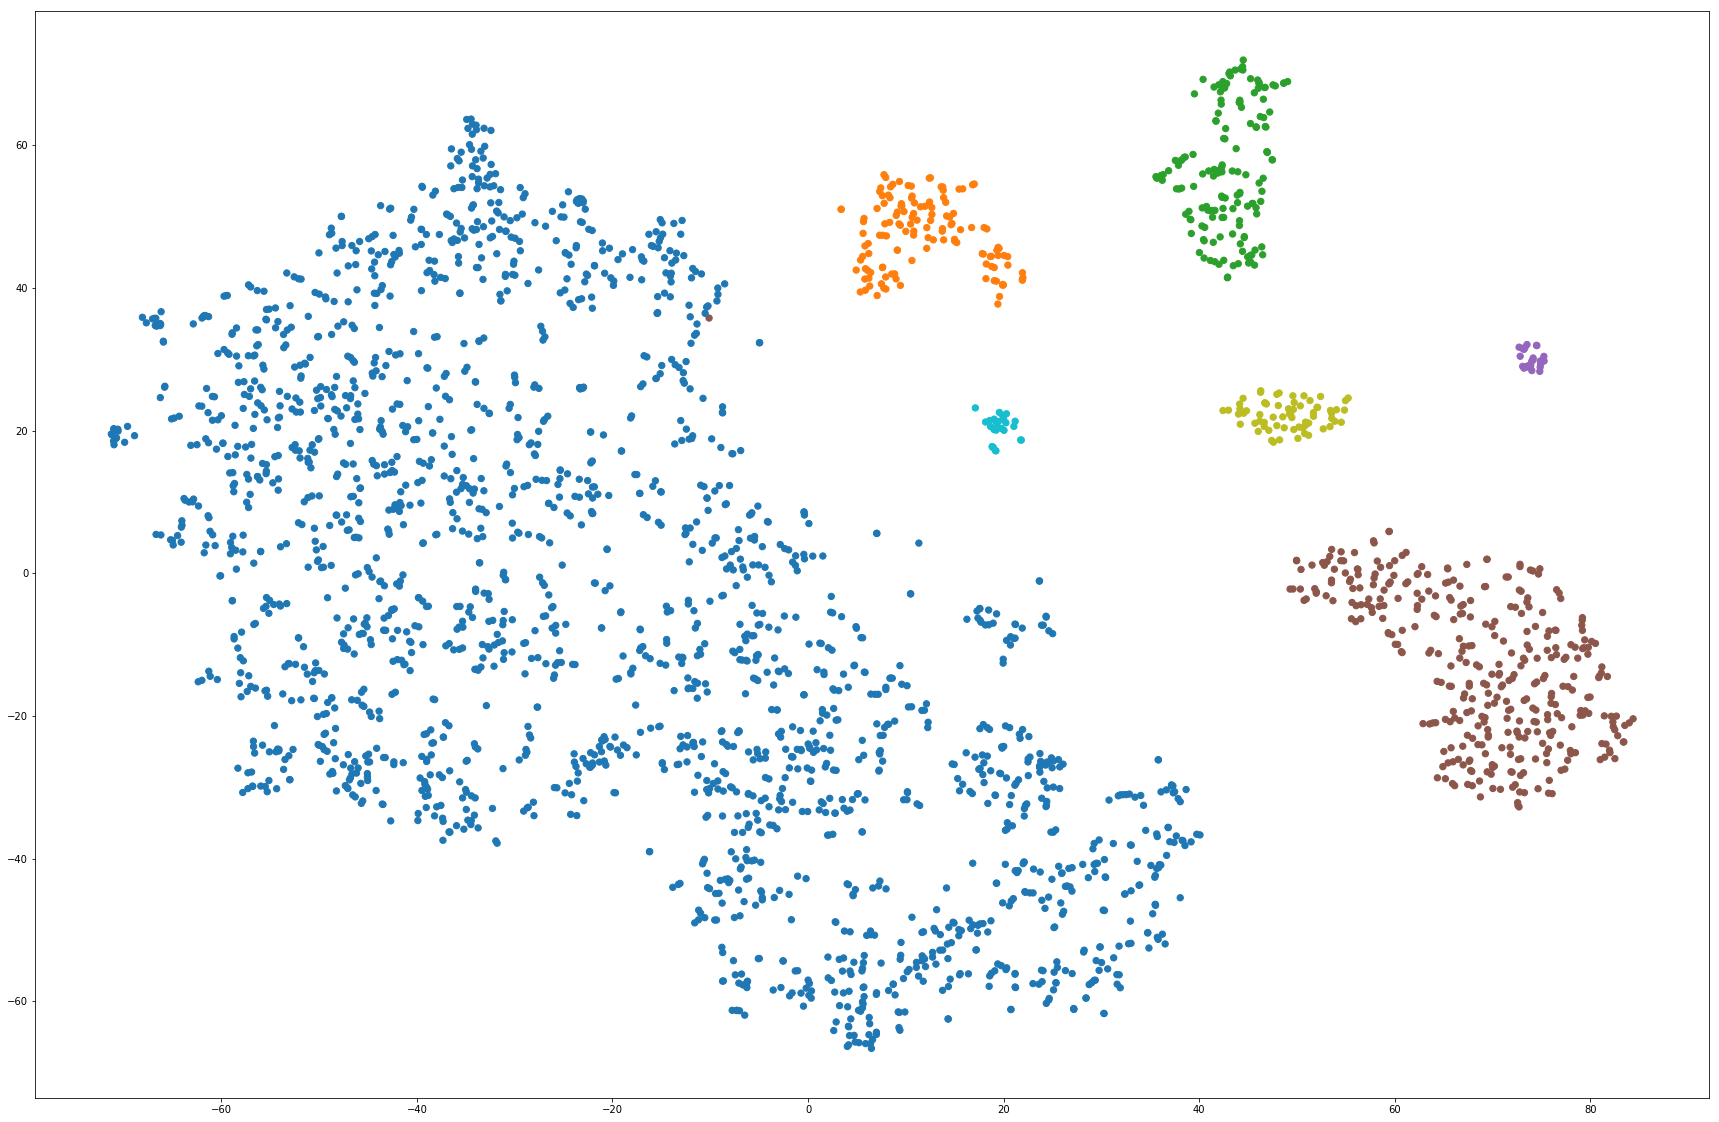

In [19]:
import matplotlib.pyplot as plt

mask = (gt_labels != -1)
plt.figure(figsize=(30, 20))
plt.scatter(X_tsne[:,0][mask], X_tsne[:,1][mask], c=gt_labels[mask], s=40, cmap=plt.cm.get_cmap('tab10'))
plt.show()

# Predict class using features

In [21]:
# Evaluate baseline softmax method
from train import eval, eval_mahal

print('load data') 
test_dataset = TestDataset(opt)
test_dataloader = DataLoader(test_dataset,
                             batch_size=1,
                             shuffle=False,
                             pin_memory=True,
                             num_workers=opt.num_workers)

# baseline_result = eval(test_dataloader, trainer.faster_rcnn, test_num=3768)
# with open("baseline_results.pickle", 'wb') as f:
#     pickle.dump(baseline_result, f)
    
with open("baseline_results.pickle", 'rb') as f:
    baseline_result = pickle.load(f)
    
print(baseline_result)

load data
{'ap': array([0.80918346, 0.79683744, 0.90151216, 0.90841999, 0.60692941,
       0.65809045, 0.69562252, 0.77759464]), 'map': 0.769273758961011}


/home/tadenoud/Git/simple-faster-rcnn-pytorch/train.py:26: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('agg')


In [22]:
# Evaluate mahalanobis distance method
# mahal_result = eval_mahal(test_dataloader, trainer.faster_rcnn, test_num=3768)

# with open("mahal_result.pickle", "wb") as f:
#     pickle.dump(mahal_result, f)
    
# with open("mahal_result.pickle", "rb") as f:
#     mahal_result = pickle.load(f)
    
# print(mahal_result)

> /home/tadenoud/Git/simple-faster-rcnn-pytorch/model/faster_rcnn.py(438)predict_label_mahalanobis()
-> return dists.argmax(axis=1), dists.max(axis=1)
(Pdb) c


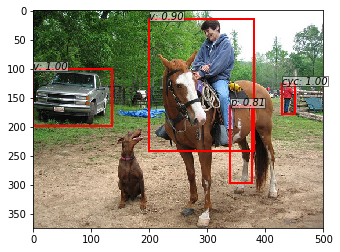

In [23]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

> /home/tadenoud/Git/simple-faster-rcnn-pytorch/model/faster_rcnn.py(438)predict_label_mahalanobis()
-> return dists.argmax(axis=1), dists.max(axis=1)
(Pdb) c
> /home/tadenoud/Git/simple-faster-rcnn-pytorch/model/faster_rcnn.py(438)predict_label_mahalanobis()
-> return dists.argmax(axis=1), dists.max(axis=1)
(Pdb) c


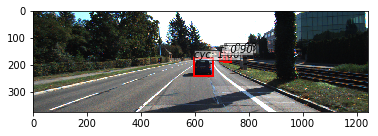

In [24]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(imgs,visualize=True)
vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

In [20]:
# VOC_BBOX_LABEL_NAMES = (
#     'car': blue,
#     'van': orange,
#     'truck': green,
#     'tram': red,
#     'person': purple,
#     'person_sitting': brown,
#     'cyclist': brown,
#     'misc': gray
#     # 'dontcare
# )